In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import rasterio
%matplotlib inline
sns.set_context('paper')
sns.set_palette("husl")
sns.set_style("darkgrid")

ModuleNotFoundError: No module named 'pandas'

In [2]:
# Construct the synthetic snowcovers

uniform_snow = np.ones([512, 512])

mu = 1.2
sigma = 0.15
random_normal = np.random.normal(mu, sigma, (512,512))
#random_0to1 = np.random.uniform(0, 1, [512, 512])

x, y = np.ogrid[-np.pi:np.pi:512j, -np.pi:np.pi:512j]
egg_carton = np.abs(np.tan(x) + np.tan(y))

n = int(512**2 / 4)
n2 = n*2
data = np.concatenate((np.random.normal(0.4, 0.2, n2), np.random.normal(1, 0.3, n2)))
data=data.reshape(512,512)

In [3]:
def find_drift_threshold(snow):

    # Compute some basic stats
    mean_depth = np.nanmean(snow)
    std_depth = np.nanstd(snow)
    cv_depth = std_depth / mean_depth

    # Thresholds to test (percentages of the mean depth)
    # Expect the threshold to be above average depth
    thresholds = np.round(np.arange(0.8, 2.3, 0.1) * mean_depth, 2)

    # Computing total area / volume of all snow pixels
    pxl_sz = 1
    total_area = (~np.isnan(snow)).sum() * pxl_sz
    total_volume = np.nansum((~np.isnan(snow)) * snow * pxl_sz)
    
    # Compute depth thresholds
    d = dict()
    for i in thresholds:

        k = str(i) + ' m'
        #print('testing threshold of ' + k + '...')

        drift_mask = (snow >= i)
        depth_drift_masked = drift_mask * snow
        depth_drift_masked[depth_drift_masked == 0] = np.nan
        
        not_drift_mask = (snow < i)
        depth_not_drift_masked = not_drift_mask * snow
        depth_not_drift_masked[depth_not_drift_masked == 0] = np.nan

        d[k] = {}
        d[k]['drift_area'] = int(np.nansum(drift_mask))
        d[k]['not_drift_area'] = int(np.nansum(not_drift_mask))
        d[k]['drift_volume'] = int(np.nansum(drift_mask * snow * pxl_sz))
        d[k]['not_drift_volume'] = int(np.nansum(not_drift_mask * snow * pxl_sz))

        
    # Move to dict to df
    df = pd.DataFrame.from_dict(d).T
    df['Drift Threshold (pct. of mean depth)'] = np.arange(0.8, 2.3, 0.1) * 100
    df['Drift Area pct.'] = df.drift_area / total_area * 100
    df['Not Drift Area pct.'] = df.not_drift_area / total_area * 100
    df['Drift Volume pct.'] = df.drift_volume / total_volume * 100
    df['Not Drift Volume pct.'] = df.not_drift_volume / total_volume * 100
    
    # Find the inflection Threshold
    df['Drift Volume-Area Difference (pct.)'] = df['Drift Volume pct.'] - df['Drift Area pct.']
    df['Drift Volume-Area Difference Slope'] = np.gradient(df['Drift Volume-Area Difference (pct.)'])
    df.set_index(df['Drift Threshold (pct. of mean depth)'], inplace=True)
    inflection = df['Drift Volume-Area Difference Slope'].idxmin()
    df['Inflection Threshold'] = inflection

    return df, inflection
# df['Mean_Depth [m]'] = mean_depth
# df['SD Depth [m]'] = std_depth
# df['CV'] = cv_depth

# print(inflection)

# # Write this data out to a .csv file
# df.to_csv('results/drift_thresholds_' + mtn + study_area +'_' + year + '.csv')


In [4]:
unif_res, unif_thresh = find_drift_threshold(uniform_snow)
bi_res, bi_thresh = find_drift_threshold(data)
ran_res, ran_thresh = find_drift_threshold(random_normal)

unif_thresh = 100
bi_res.tail()


,drift_area,drift_volume,not_drift_area,not_drift_volume,Drift Threshold (pct. of mean depth),Drift Area pct.,Not Drift Area pct.,Drift Volume pct.,Not Drift Volume pct.,Drift Volume-Area Difference (pct.),Drift Volume-Area Difference Slope,Inflection Threshold
Drift Threshold (pct. of mean depth),,,,,,,,,,,,
180.0,25177,35888,236967,147640,180.0,9.604263,90.395737,19.554438,80.445196,9.950175,-2.554915,170.0
190.0,17701,26216,244443,157312,190.0,6.752396,93.247604,14.284417,85.715218,7.532021,-2.259126,170.0
200.0,11888,18292,250256,165236,200.0,4.534912,95.465088,9.966835,90.032799,5.431923,-1.887481,170.0
210.0,7697,12284,254447,171243,210.0,2.936172,97.063828,6.693232,93.305857,3.757060,-1.505222,170.0
220.0,4642,7694,257502,175834,220.0,1.770782,98.229218,4.192261,95.807374,2.421478,-1.335582,170.0


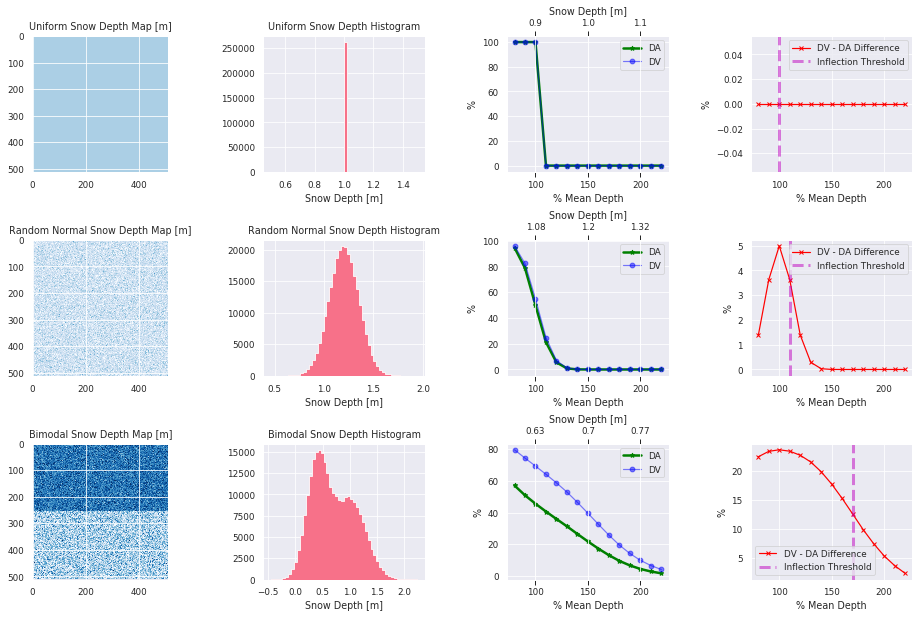

In [7]:

f, axes = plt.subplots(3, 4, figsize=(16,10))
f.subplots_adjust(hspace=0.5, wspace=0.51)

# Uniform

axes[0][0].imshow(uniform_snow, vmin=0, vmax=1.5, cmap='Blues_r')
axes[0][0].set_title('Uniform Snow Depth Map [m]')


axes[0][1].hist(uniform_snow.flatten(), bins=50, histtype='stepfilled')
axes[0][1].set_title('Uniform Snow Depth Histogram')
axes[0][1].set_xlabel('Snow Depth [m]')


axes[0][2].plot(unif_res['Drift Threshold (pct. of mean depth)'],
                   unif_res['Drift Area pct.'], '-g*', label = 'DA', lw=2.5)
axes[0][2].plot(unif_res['Drift Threshold (pct. of mean depth)'],
                   unif_res['Drift Volume pct.'], '-bo', label = 'DV', alpha=0.5)
axes[0][2].set_ylabel('%')
axes[0][2].set_xlabel('% Mean Depth')
axes[0][2].legend()


ax2 = axes[0][2].twiny()
ax1Xs = axes[0][2].get_xticks()
ax2Xs = []
for t in unif_res['Drift Threshold (pct. of mean depth)'].values:
    ax2Xs.append(round(uniform_snow.mean() * (t/100), 2))
ax2.set_xticks(ax1Xs)
ax2.set_xbound(axes[0][2].get_xbound())
ax2.set_xticklabels(ax2Xs)
ax2.set_xlabel('Snow Depth [m]')


axes[0][3].plot(unif_res['Drift Threshold (pct. of mean depth)'], unif_res['Drift Volume-Area Difference (pct.)'],
                '-rx', label = 'DV - DA Difference')
axes[0][3].axvline(x=unif_thresh, color='m', alpha=0.5, lw=3, ls='--', label = 'Inflection Threshold')
axes[0][3].set_xlabel('% Mean Depth')
axes[0][3].set_ylabel('%')

axes[0][3].legend()


# Normal ###

axes[1][0].imshow(random_normal, vmin=0, vmax=1.5, cmap='Blues_r')
axes[1][0].set_title('Random Normal Snow Depth Map [m]')

#

axes[1][1].hist(random_normal.flatten(), bins=50, histtype='stepfilled')
axes[1][1].set_title('Random Normal Snow Depth Histogram')
axes[1][1].set_xlabel('Snow Depth [m]')
#

axes[1][2].plot(ran_res['Drift Threshold (pct. of mean depth)'],
                   ran_res['Drift Area pct.'], '-g*', label = 'DA', lw=2.5)
axes[1][2].plot(ran_res['Drift Threshold (pct. of mean depth)'],
                   ran_res['Drift Volume pct.'], '-bo', label = 'DV', alpha=0.5)
axes[1][2].set_ylabel('%')
axes[1][2].set_xlabel('% Mean Depth')
axes[1][2].legend()


ax3 = axes[1][2].twiny()
ax1Xs = axes[1][2].get_xticks()
ax3Xs = []
for t in ran_res['Drift Threshold (pct. of mean depth)'].values:
    ax3Xs.append(round(random_normal.mean() * (t/100), 2))
ax3.set_xticks(ax1Xs)
ax3.set_xbound(axes[1][2].get_xbound())
ax3.set_xticklabels(ax3Xs)
ax3.set_xlabel('Snow Depth [m]')


axes[1][3].plot(ran_res['Drift Threshold (pct. of mean depth)'], ran_res['Drift Volume-Area Difference (pct.)'],
                '-rx', label = 'DV - DA Difference')

axes[1][3].axvline(x=ran_thresh, color='m', alpha=0.5, lw=3, ls='--', label = 'Inflection Threshold')
axes[1][3].legend()
axes[1][3].set_xlabel('% Mean Depth')
axes[1][3].set_ylabel('%')

# #


# Bimodal

axes[2][0].imshow(data, vmin=0, vmax=1.5, cmap='Blues_r')
axes[2][0].set_title('Bimodal Snow Depth Map [m]')

#

axes[2][1].hist(data.flatten(), bins=50, histtype='stepfilled')
axes[2][1].set_title('Bimodal Snow Depth Histogram')
axes[2][1].set_xlabel('Snow Depth [m]')
#

axes[2][2].plot(bi_res['Drift Threshold (pct. of mean depth)'],
                   bi_res['Drift Area pct.'], '-g*', label = 'DA', lw=2.5)
axes[2][2].plot(bi_res['Drift Threshold (pct. of mean depth)'],
                   bi_res['Drift Volume pct.'], '-bo', label = 'DV', alpha=0.5)
axes[2][2].set_ylabel('%')
axes[2][2].set_xlabel('% Mean Depth')
axes[2][2].legend()

ax4 = axes[2][2].twiny()
ax1Xs = axes[2][2].get_xticks()
ax4Xs = []
for t in bi_res['Drift Threshold (pct. of mean depth)'].values:
    ax4Xs.append(round(data.mean() * (t/100), 2))
ax4.set_xticks(ax1Xs)
ax4.set_xbound(axes[2][2].get_xbound())
ax4.set_xticklabels(ax4Xs)
ax4.set_xlabel('Snow Depth [m]')

axes[2][3].plot(bi_res['Drift Threshold (pct. of mean depth)'], bi_res['Drift Volume-Area Difference (pct.)'],
                '-rx', label = 'DV - DA Difference')

axes[2][3].axvline(x=bi_thresh, color='m', alpha=0.5, lw=3, ls='--', label = 'Inflection Threshold')
axes[2][3].set_xlabel('% Mean Depth')
axes[2][3].set_ylabel('%')


axes[2][3].legend()



# f.suptitle('CLPX Outcrops 2012 vs. 2018: Snow Depth Pattern Similarity Maps and Surface Profiles',
#            size=16, y=0.91)

# cbar_ax = f.add_axes([0.15, 0.05, 0.65, 0.051])
# f.colorbar(im, cax=cbar_ax, orientation='horizontal')
# #f.savefig('../figures/iqamaps_snowprofiles.png', dpi=300, bbox_inches='tight')

    





# plt.axvline(x=inflection, color='m', alpha=0.5, lw=3, label = 'Inflection Threshold')
# plt.plot(df['Drift Threshold (pct. of mean depth)'], df['Drift Area pct.'], '-b*', label = 'Drift Area pct.')
# plt.plot(df['Drift Threshold (pct. of mean depth)'], df['Drift Volume pct.'], '-bo', label = 'Drift Volume pct.')

# plt.plot(df['Drift Threshold (pct. of mean depth)'], df['Drift Volume-Area Difference (pct.)'], '-gx', lw=3, label = 'Drift Volume-Area Difference')

# plt.xlabel('Drift Threshold (pct. of mean depth)')
# plt.ylabel('pct.')

plt.savefig('../figures/synthetic_snow_drift_thresholds.png', dpi=300, bbox_inches='tight')

